### Добавляем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

### Грузим датасет

In [16]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('./data/train.csv')
data_train, data_test = train_test_split(data, test_size=0.2)

In [3]:
data.sample(5)

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
2197377,2197377,p,16.70,x,k,n,t,p,NaN,e,...,c,NaN,y,NaN,NaN,f,f,NaN,d,a
339218,339218,p,5.42,x,NaN,w,f,NaN,c,w,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
1087566,1087566,p,4.87,c,i,y,f,NaN,c,r,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
736312,736312,e,2.32,f,y,n,f,a,d,p,...,NaN,i,n,NaN,NaN,f,f,NaN,h,u
1115881,1115881,p,10.83,s,t,k,t,d,c,n,...,NaN,NaN,r,NaN,NaN,f,f,NaN,l,u


Процент пропусков в каждой из колонок

In [ ]:
# def na_percentage(feature):
# 	cnt_nulls = sum(data_train[feature].isna())
# 	n_rows = data_train.shape[0]
# 	percentage = round(cnt_nulls / n_rows * 100)
# 	print(f'{feature}: {cnt_nulls} / {n_rows} = {percentage}%')
# 	print(data_train[feature].dtype)

# for col in data_train.columns:
# 	na_percentage(col)

### Preprocessing

In [2]:
#Автор: Антон Шмелев
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import csr_matrix, hstack

class DataPreprocessor(TransformerMixin, BaseEstimator):
	def __init__(self, needed_columns=None, valid_values=None, target_column=None):
		self.scaler = StandardScaler()
		self.ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
		self.needed_columns = needed_columns
		self.valid_values = valid_values
		self.categorical_columns = []
		self.continuous_columns = []
		self.target_column = target_column

	def fit(self, X):
		data = X.copy()

		if self.needed_columns is not None:
			data = data[self.needed_columns]

		if self.target_column in data.columns:
			data = data.drop(columns=[self.target_column])

		self.continuous_columns = [col for col in data.columns if data[col].dtype in ('float64', 'int64') and col != self.target_column]
		self.categorical_columns = [col for col in data.columns if data[col].dtype not in ('float64', 'int64') and col != self.target_column]

		if self.valid_values is not None:
			for col in self.categorical_columns:
				data = data[data[col].isin(self.valid_values[col])]

		self.ohe.fit(data[self.categorical_columns])
		self.scaler.fit(data[self.continuous_columns])

		return self
	
	def transform(self, X):
		data = X.copy()

		targetExists = self.target_column in data.columns

		if self.needed_columns is not None:
			data = data[self.needed_columns + [self.target_column] if targetExists else self.needed_columns]

		for col in self.categorical_columns:
			data.loc[:, col] = data[col].fillna(data[col].mode(dropna=True)[0])

		for col in self.continuous_columns:
			data.loc[:, col] = data[col].fillna(data[col].median())

		if self.valid_values is not None:
			for col in self.categorical_columns:
				data = data[data[col].isin(self.valid_values[col])]

		if targetExists:
			y = data[self.target_column]
			data = data.drop(columns=[self.target_column])

		data1 = self.scaler.transform(data[self.continuous_columns])
		data2 = self.ohe.transform(data[self.categorical_columns])
		
		X_transformed = hstack([csr_matrix(data1), data2]) 

		return (X_transformed, y) if targetExists else X_transformed

### Predictions

In [17]:
#Автор: Антон Шмелев
needed_columns = [
 	'cap-shape',
 	'cap-surface',
 	'cap-color',
 	'does-bruise-or-bleed',
 	'gill-attachment',
 	'gill-color',
 	'stem-color',
 	'has-ring',
 	'ring-type',
 	'habitat',
 	'season',
    'cap-diameter',
	'stem-height',
	'stem-width'
]

valid_values = {
	'class': ['p', 'e'],
	'cap-shape': ['b', 'c', 'x', 'f', 'k', 's'],
	'cap-surface': ['f', 'g', 'y', 's'],
	'cap-color': ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y'],
	'does-bruise-or-bleed': ['f', 't'],
	'gill-attachment': ['a', 'd', 'f', 'n'],
	'gill-color': ['k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y'],
	'stem-color': ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'],
	'has-ring': ['f', 't'],
	'ring-type': ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z'],
	'habitat': ['g', 'l', 'm', 'p', 'u', 'w', 'd'],
	'season': ['a', 'w', 'u', 's']
}

preprocessor = DataPreprocessor(
	needed_columns=needed_columns, 
	valid_values=valid_values, 
	target_column='class'
)

X_train, y_train = preprocessor.fit_transform(data_train)

In [18]:
X_test, y_test = preprocessor.transform(data_test)

In [19]:
from catboost import CatBoostClassifier

classifier = CatBoostClassifier()
classifier.fit(X_train, y_train)

Learning rate set to 0.121397
0:	learn: 0.6136797	total: 46.4ms	remaining: 46.4s
1:	learn: 0.5504034	total: 90ms	remaining: 44.9s
2:	learn: 0.4553247	total: 136ms	remaining: 45.1s
3:	learn: 0.4149871	total: 180ms	remaining: 44.7s
4:	learn: 0.3642754	total: 229ms	remaining: 45.6s
5:	learn: 0.3268863	total: 280ms	remaining: 46.4s
6:	learn: 0.3040064	total: 337ms	remaining: 47.8s
7:	learn: 0.2743635	total: 384ms	remaining: 47.6s
8:	learn: 0.2477085	total: 432ms	remaining: 47.6s
9:	learn: 0.2303983	total: 474ms	remaining: 47s
10:	learn: 0.2140501	total: 516ms	remaining: 46.4s
11:	learn: 0.2036060	total: 557ms	remaining: 45.9s
12:	learn: 0.1932610	total: 601ms	remaining: 45.6s
13:	learn: 0.1814371	total: 649ms	remaining: 45.7s
14:	learn: 0.1727172	total: 695ms	remaining: 45.7s
15:	learn: 0.1657820	total: 741ms	remaining: 45.6s
16:	learn: 0.1564068	total: 785ms	remaining: 45.4s
17:	learn: 0.1516579	total: 827ms	remaining: 45.1s
18:	learn: 0.1446969	total: 875ms	remaining: 45.2s
19:	learn: 0.

In [20]:
y_pred = classifier.predict(X_test)
y_score = classifier.predict_proba(X_test)[:, 1]

In [ ]:
#Авторы: Ро Александр
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f'f1 score: {f1_score(y_test, y_pred, average='binary', pos_label='p')}')
print(f'roc_auc: {roc_auc_score(y_test, y_score)}')

# Графики

In [ ]:
#Автор: Андреев Александр
remove_cols = [
	'id',
	'stem-root',
	'stem-surface',
	'veil-type',
	'veil-color',
	'spore-print-color',
	'gill-spacing'
]

data = data.drop(columns=remove_cols)

In [17]:
categorical_columns = [key for key in data.keys() if data[key].dtype not in ('float64', 'int64')]
categorical_columns

['class',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-color',
 'stem-color',
 'has-ring',
 'ring-type',
 'habitat',
 'season']

In [18]:
#Автор: Чапайкин Арсений
valid_values = {
	'class': ['p', 'e'],
	'cap-shape': ['b', 'c', 'x', 'f', 'k', 's'],
	'cap-surface': ['f', 'g', 'y', 's'],
	'cap-color': ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y'],
	'does-bruise-or-bleed': ['f', 't'],
	'gill-attachment': ['a', 'd', 'f', 'n'],
	'gill-color': ['k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y'],
	'stem-color': ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'],
	'has-ring': ['f', 't'],
	'ring-type': ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z'],
	'habitat': ['g', 'l', 'm', 'p', 'u', 'w', 'd'],
	'season': ['a', 'w', 'u', 's']
}

for col in categorical_columns:
	data[col] = data[col].fillna(data[col].mode()[0])
	data = data[data[col].isin(valid_values[col])]

data.shape

(403832, 15)

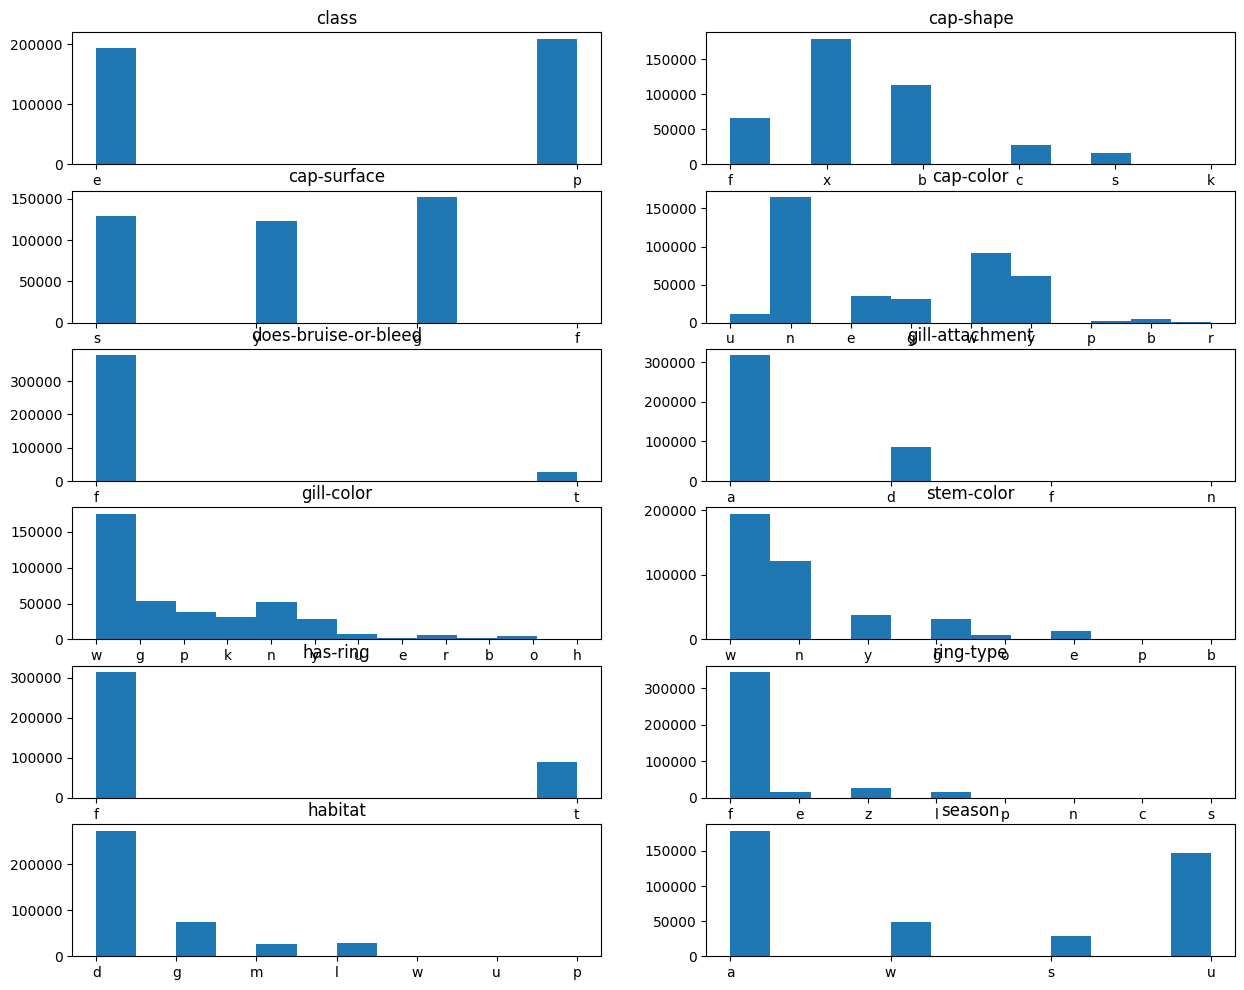

In [19]:
#Автор: Ро Александр
ncols = 2
nrows = (len(categorical_columns) + ncols - 1) // ncols
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 6*ncols))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
	try:
		axes[i].hist(data[col], bins=12)
		axes[i].set_title(col)
	except:
		print(col)

plt.show()

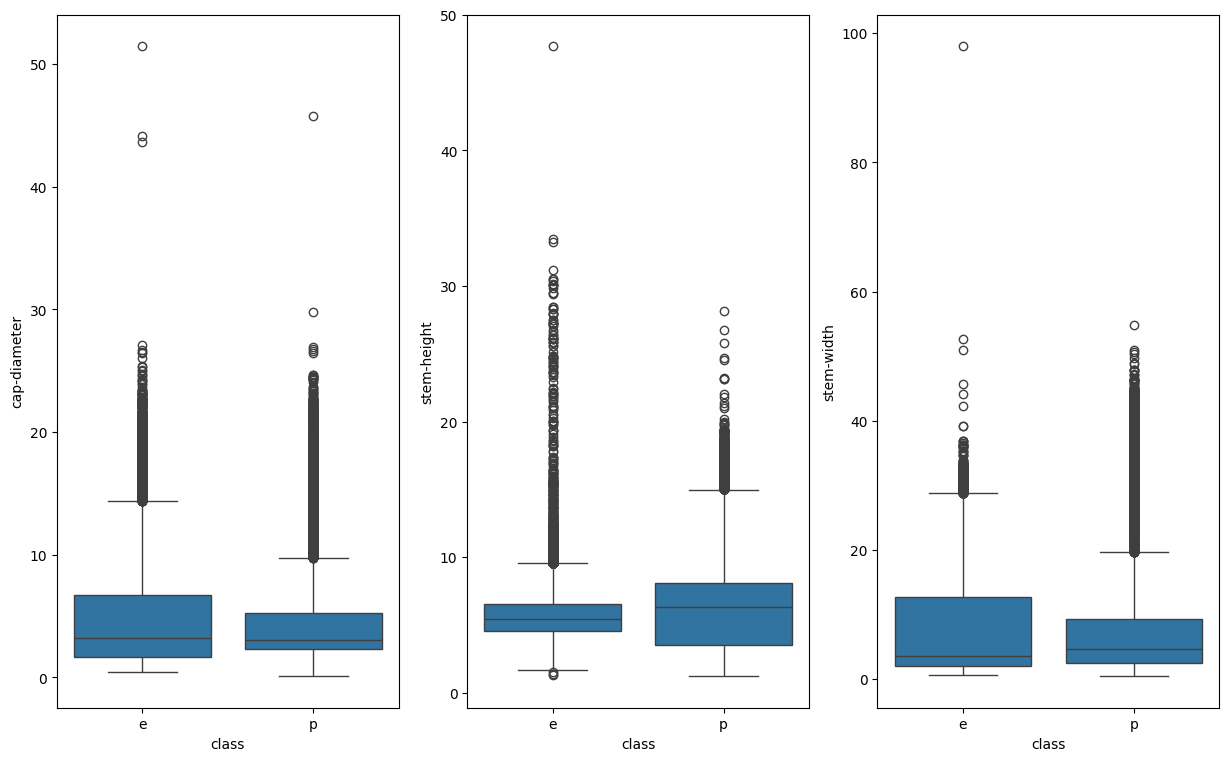

In [20]:
#Автор: Шмелев Антон
continuous_columns = [key for key in data.keys() if data[key].dtype in ('int64', 'float64')]

ncols = 3
nrows = (len(continuous_columns) + ncols - 1) // ncols
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 3*ncols))
axes = axes.flatten()

for i, col in enumerate(continuous_columns):
	sns.boxplot(data=data, x='class', y=col, ax=axes[i])

plt.show()